# **Chapter 14**
## *Outlier Detection Using Unsupervised Machine Learning*, 

This chapter continues from **Chapter 8**, *Outlier Detection Using Statistical Methods*, but focuses on more advanced **unsupervised machine learning** methods. You will use the same datasets from the NAB to allow you to compare statistical and machine learning techniques using the same benchmark data. The techniques cover a variety of machine learning algorithms.


You will be using the same New York taxi dataset to make it easier to compare the results between the different machine learning methods in this chapter and the statistical methods from **Chapter 8**, *Outlier Detection Using Statistical Methods*.  

The recipes that you will encounter in this chapter are as follows:
* Detecting outliers using KNN
* Detecting outliers using LOF
* Detecting outliers using iForest
* Detecting outliers using One-Class Support Vector Machine (OCSVM)
* Detecting outliers using COPOD
* Detecting outliers with PyCaret **see Chapter-14-pycaret** notebook

In [1]:
import matplotlib 
import pandas as pd
import pyod 
import statsmodels

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
statsmodels -> {statsmodels.__version__}
''')


Matplotlib -> 3.9.2
pandas -> 2.2.2   
statsmodels -> 0.14.2



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 3]

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

### Create DataFrames 

In [4]:
url1 = ("https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/refs/heads/main/datasets/Ch14/nyc_taxi.csv")

nyc_taxi = pd.read_csv(url1, 
                     index_col='timestamp', 
                     parse_dates=True)
nyc_taxi

value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820
...                    ...
2015-01-31 21:30:00  24670
2015-01-31 22:00:00  25721
2015-01-31 22:30:00  27309
2015-01-31 23:00:00  26591
2015-01-31 23:30:00  26288

[10320 rows x 1 columns]

In [5]:
def plot_outliers(outliers, data, method='KNN',             # Define a function to visualize outliers on time series data
                 halignment='right',                        # Horizontal alignment for labels (default: right)
                 valignment='top',                          # Vertical alignment for labels (default: top)
                 labels=False,                              # Whether to label outlier points with dates
                 name=None):                                # Optional name argument (not used inside the function)

    ax = data.plot(alpha=0.6)                               # Plot the original time series with partial transparency

    if labels:                                              # If labels are requested:
        for i in outliers['value'].items():                 # Iterate over outlier points (index: date, value: y)
            plt.plot(i[0], i[1], 'v',                       # Mark outlier with a black open triangle
                     markersize=8, markerfacecolor='none', markeredgecolor='k')
            plt.text(i[0], i[1] - (i[1] * 0.04),            # Add date label slightly below the marker
                     f'{i[0].strftime("%m/%d")}', 
                     horizontalalignment=halignment,
                     verticalalignment=valignment)
    else:
        data.loc[outliers.index].plot(ax=ax,                # If no labels, just plot outliers as red 'X'
                                      style='rX', markersize=9)

    plt.title(f'NYC Taxi - {method}')                       # Add title with detection method name
    plt.xlabel('date')                                      # X-axis label
    plt.ylabel('Number of passengers')                      # Y-axis label
    plt.legend(['nyc taxi', 'outliers'])                    # Add legend
    plt.show()                                              # Display the plot

### Visualize DataFrames

In [6]:
nyc_taxi.index

DatetimeIndex(['2014-07-01 00:00:00', '2014-07-01 00:30:00',
               '2014-07-01 01:00:00', '2014-07-01 01:30:00',
               '2014-07-01 02:00:00', '2014-07-01 02:30:00',
               '2014-07-01 03:00:00', '2014-07-01 03:30:00',
               '2014-07-01 04:00:00', '2014-07-01 04:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=10320, freq=None)

In [7]:
nyc_dates =  [
        "2014-11-01",
        "2014-11-27",
        "2014-12-25",
        "2015-01-01",
        "2015-01-27"
]

tx = nyc_taxi.resample('D').mean()     # Resample the NYC taxi time series to daily frequency by taking the daily mean
known_outliers = tx.loc[nyc_dates]     # Select the known outlier dates from the resampled data using the nyc_dates list/index

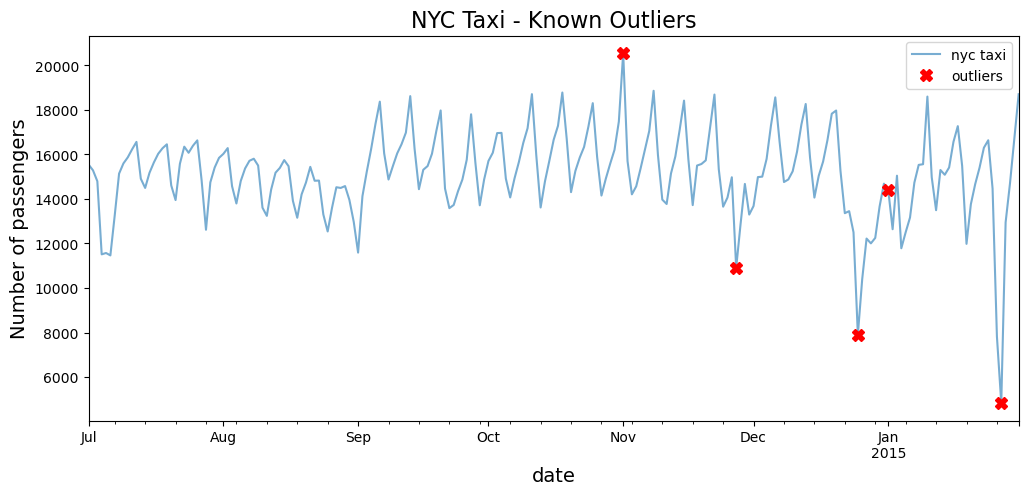

In [8]:
plot_outliers(known_outliers, tx, 'Known Outliers')

# Detecting Outliers using K-Nearest Neighbors

In [9]:
from pyod.models.knn import KNN

In [10]:
knn = KNN(contamination=0.03,     # Set the expected proportion of outliers to 3% of the data
          method='mean',          # Use the mean distance to k neighbors as the decision function
          n_neighbors=5)          # Use 5 nearest neighbors to detect anomalies

In [11]:
knn.fit(tx)

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [12]:
predicted = pd.Series(knn.predict(tx), # Apply the KNN outlier detector to the resampled NYC taxi data and return binary predictions(0=inlier,1=outlier)
                      index=tx.index)  # Assign the original datetime index to the prediction series for alignment with the data

In [13]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [14]:
# Retrieves the values in the resampled daily NYC taxi data that correspond to the known outlier dates stored in `nyc_dates`
tx.loc[nyc_dates]

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667

In [15]:
outliers = predicted[predicted == 1]   # Filter the predicted Series to keep only the outlier points (where prediction == 1)
outliers = tx.loc[outliers.index]      # Retrieve the actual outlier values from the original data using their indices
 
outliers

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

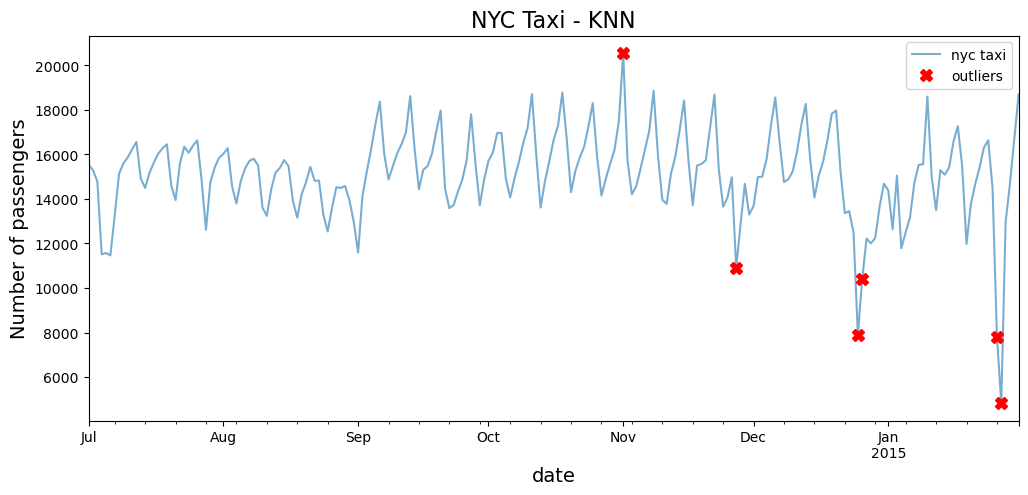

In [16]:
plot_outliers(outliers, tx, 'KNN')

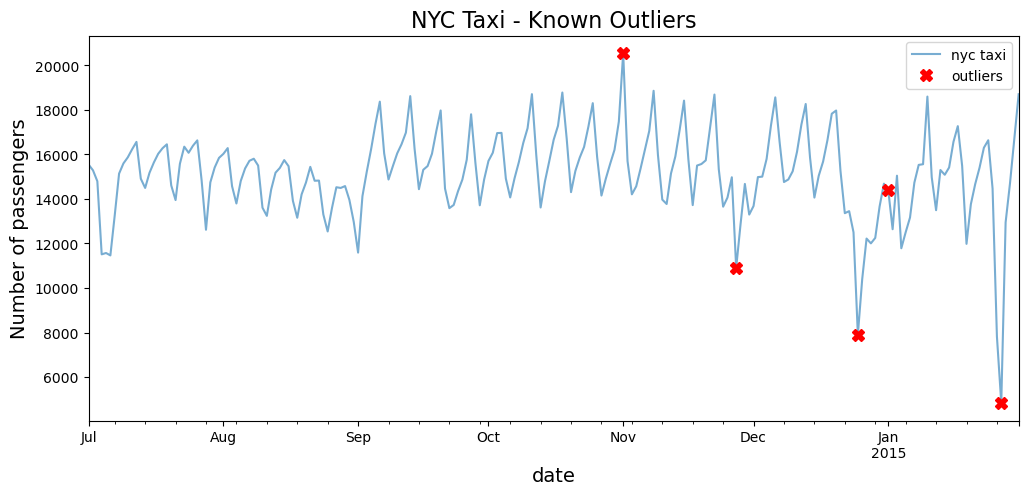

In [17]:
plot_outliers(known_outliers, tx, 'Known Outliers')

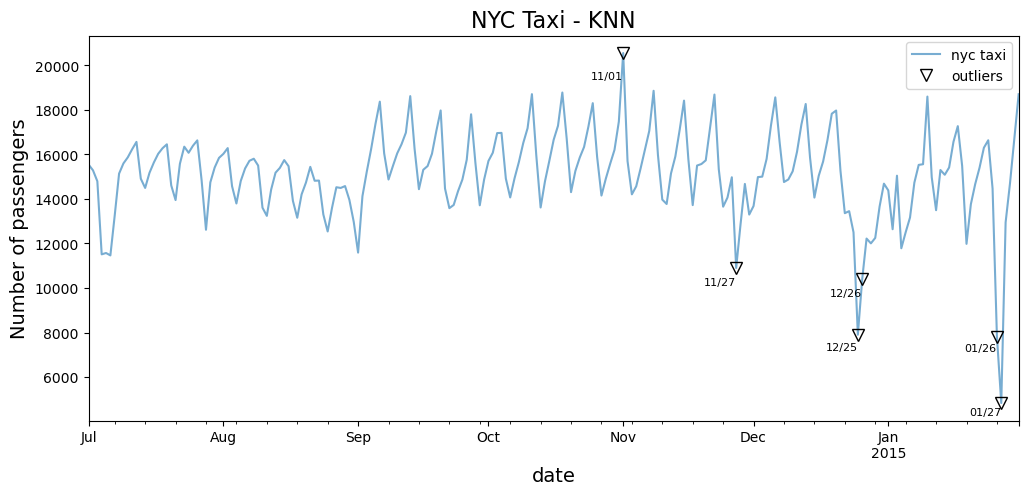

In [18]:
plot_outliers(outliers,      # Pass the detected outliers to be plotted
              tx,            # Full daily NYC taxi dataset
              'KNN',         # Label the method used in the plot title
              labels=True)   # Enable labels to show the date of each outlier on the plot

## How it works

In [19]:
knn_scores = knn.decision_scores_            # Get the raw outlier scores assigned by the KNN detector for each data point

knn_scores_df = (pd.DataFrame(knn_scores,    # Create a DataFrame from the scores
                 index=tx.index,             # Use the original datetime index
                 columns=['score']))         # Name the column 'score'

# Filter for points with scores above the model's threshold (classified as outliers)
knn_scores_df[knn_scores_df['score'] >= knn.threshold_].sort_values('score', ascending=False)

score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167

In [20]:
n = int(len(tx) * 0.03)              # Calculate the number of top outliers to select (3% of the total data points)
knn_scores_df.nlargest(n, 'score')   # Select the top-n data points with the highest KNN outlier scores

score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000

In [21]:
# Returns the minimum outlier score in the KNN score DataFrame
knn_scores_df.min()

score    11.745833
dtype: float64

In [22]:
# Returns the maximum outlier score in the KNN score DataFrame
knn_scores_df.max()

score    4862.058333
dtype: float64

In [23]:
(2474.508333 - 11.745833)*100/(4862.058333-11.745833)

50.77533664068037

In [24]:
knn_proba = knn.predict_proba(tx, method='linear')           # Compute anomaly probabilities using the linear method 

knn_proba_df = (pd.DataFrame(np.round(knn_proba * 100, 3),   # Convert probabilities to percentage (rounded to 3 decimals)
            index=tx.index,                                  # Keep original date index
            columns=['Proba_Normal', 'Proba_Anomaly']))      # Label columns: probability of being normal vs anomaly

knn_proba_df.nlargest(n, 'Proba_Anomaly')                    # Select the top-n rows with the highest probability of being an anomaly

Proba_Normal  Proba_Anomaly
timestamp                              
2015-01-27        27.337         72.663
2015-01-26        64.256         35.744
2014-12-25        64.599         35.401
2014-11-01        70.682         29.318
2014-12-26        84.341         15.659
2014-11-27        90.548          9.452

In [25]:
from joblib import dump, load

# save the model
dump(knn, 'knn_outliers.joblib')

# load the model
knn = load('knn_outliers.joblib')

In [26]:
knn

KNN(algorithm='auto', contamination=0.03, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

## There is more

In [27]:
from pyod.utils.utility import standardizer

scaled = standardizer(tx)                           # Apply standardization to the time series

predicted = pd.Series(knn.fit_predict(scaled),      # Fit and predict on the scaled data using KNN
                      index=tx.index)

outliers_scaled = predicted[predicted == 1]         # Keep only the predicted outliers (1s)

outliers_scaled = tx.loc[outliers_scaled.index]     # Retrieve original (unscaled) values at those outlier indices
outliers_scaled                                     # Display the outlier time points

value
timestamp               
2014-09-27  17801.791667
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

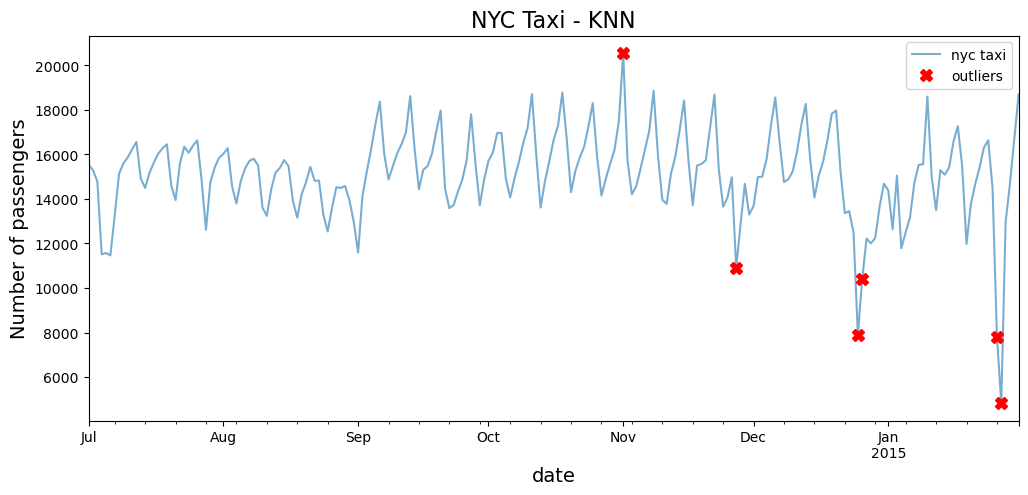

In [28]:
plot_outliers(outliers, tx, 'KNN')

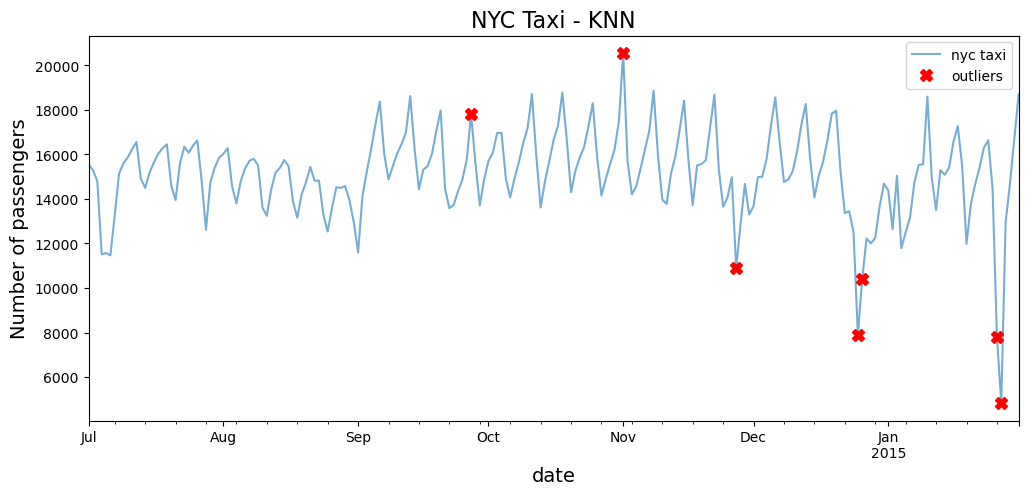

In [29]:
plot_outliers(outliers_scaled, tx, 'KNN')

In [30]:
def knn_anomaly(df, method='mean', contamination=0.05, k=5):        # Detect outliers using KNN with adjustable method and contamination

    knn = KNN(contamination=contamination,                          # Initialize KNN with given contamination level (fraction of outliers)
              method=method,                                        # Method for computing anomaly score (e.g., 'mean' or 'median')
              n_neighbors=k)                                        # Number of neighbors to consider

    knn.fit(df)                                                     # Fit the model to the data

    decision_score = pd.DataFrame(knn.decision_scores_,             # Retrieve the raw anomaly scores
                          index=df.index, 
                          columns=['score'])

    n = int(len(df) * contamination)                                # Calculate how many outliers to return

    outliers = decision_score.nlargest(n, 'score')                  # Get the top-n outliers based on score

    return outliers, knn.threshold_                                 # Return the outlier DataFrame and the threshold used

In [31]:
for method in ['mean', 'median', 'largest']:      # Loop through three different KNN scoring methods
    o, t = knn_anomaly(tx, method=method)         # Call the knn_anomaly function with each method
    print(f'Method= {method}, Threshold= {t}')    # Print the method name and the corresponding threshold
    print(o)                                      # Print the top detected outliers for that method

Method= mean, Threshold= 220.32916666666603
                  score
timestamp              
2015-01-27  4862.058333
2015-01-26  2474.508333
2014-12-25  2441.250000
2014-11-01  1806.850000
2014-12-26  1009.616667
2014-11-27   608.250000
2014-09-27   225.604167
2014-07-06   224.208333
2014-12-28   223.562500
2015-01-19   223.562500
Method= median, Threshold= 211.64999999999995
                  score
timestamp              
2015-01-27  5563.416667
2014-12-25  2997.541667
2015-01-26  2984.437500
2014-11-01  1847.083333
2014-12-26  1113.812500
2014-11-27   612.104167
2014-12-29   251.520833
2014-12-27   238.062500
2015-01-19   238.062500
2014-12-28   219.145833
Method= largest, Threshold= 411.85624999999993
                  score
timestamp              
2015-01-27  6629.729167
2015-01-26  3645.291667
2014-12-25  3562.145833
2014-11-01  1865.437500
2014-12-26  1191.916667
2014-11-27   690.208333
2014-07-06   518.583333
2014-07-04   471.083333
2014-12-19   436.604167
2014-09-27   431.750000

# Detecting Outliers Using Local Outlier Factor LOF

In [32]:
from pyod.models.lof import LOF

In [33]:
lof = LOF(contamination=0.03,  # Set the expected proportion of outliers to 3% of the dataset
          n_neighbors=5)       # Use 5 nearest neighbors to compute local density and detect anomalies

lof.fit(tx)                    # Fit the LOF model to the NYC taxi data

LOF(algorithm='auto', contamination=0.03, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, novelty=True, p=2)

In [34]:
predicted = pd.Series(lof.predict(tx),   # Predict outliers using the fitted LOF model (0 = inlier, 1 = outlier)
                      index=tx.index)    # Preserve the original datetime index in the prediction series

print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [35]:
# Retrieves the rows from the resampled NYC taxi data that correspond to the known outlier dates stored in `nyc_dates`
tx.loc[nyc_dates]

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667

In [36]:
tx.shape

(215, 1)

In [37]:
outliers = predicted[predicted == 1]  # Filter the prediction series to get only the points classified as outliers (1)
outliers = tx.loc[outliers.index]     # Retrieve the original data values at those outlier indices
outliers                              # Display the resulting outlier rows from the time series

value
timestamp               
2014-10-31  17473.354167
2014-11-01  20553.500000
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

In [38]:
# Returns the decision threshold used by the LOF model to separate inliers from outliers
lof.threshold_ 

1.7717390813973128

In [39]:
lof_scores = lof.decision_scores_           # Get the raw LOF anomaly scores for each point in the dataset

lof_scores_df = (pd.DataFrame(lof_scores,   # Create a DataFrame of scores
             index=tx.index, 
             columns=['score']))

# Filter to keep only the points with scores above or equal to the LOF threshold
lof_scores_df[lof_scores_df['score'] >= lof.threshold_].sort_values('score', ascending=False)

score
timestamp            
2014-11-01  14.254309
2015-01-27   5.270860
2015-01-26   3.988552
2014-12-25   3.952827
2014-12-26   2.295987
2014-10-31   2.158571
2015-01-12   1.796124

In [40]:
n = int(len(tx) * 0.03)               # Calculate the number of top outliers to select (3% of total data)
lof_scores_df.nlargest(n, 'score')    # Return the top-n data points with the highest LOF anomaly scores

score
timestamp            
2014-11-01  14.254309
2015-01-27   5.270860
2015-01-26   3.988552
2014-12-25   3.952827
2014-12-26   2.295987
2014-10-31   2.158571

In [41]:
lof_proba = lof.predict_proba(tx, method='linear')           # Compute anomaly probabilities using linear normalization of LOF scores

lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),   # Convert probabilities to percentage (rounded to 3 decimals)
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])       # Label columns for readability
            .sort_values('Proba_Anomaly', ascending=False)   # Sort by highest anomaly probability first
           )
lof_proba_df[:n].sort_index()                                # Return the top-n anomaly candidates, sorted back by time index

Proba_Normal  Proba_Anomaly
timestamp                              
2014-10-31        92.361          7.639
2014-11-01        22.033         77.967
2014-12-25        89.121         10.879
2014-12-26        91.625          8.375
2015-01-26        88.972         11.028
2015-01-27        83.610         16.390

In [42]:
lof_proba = lof.predict_proba(tx, method='unify')           # Compute anomaly probabilities using the 'unify' method (based on score ranking consistency)

lof_proba_df = (pd.DataFrame(np.round(lof_proba * 100, 3),  # Convert probabilities to percentages and round to 3 decimal places
            index=tx.index,
            columns=['Proba_Normal', 'Proba_Anomaly'])      # Label columns for better interpretation
            .sort_values('Proba_Anomaly', ascending=False)  # Sort by most anomalous points first
           )
lof_proba_df[:n].sort_index()                               # Return top-n anomalies sorted by date (chronological order)

Proba_Normal  Proba_Anomaly
timestamp                              
2014-10-31        47.955         52.045
2014-11-01         0.000        100.000
2014-12-25        25.309         74.691
2014-12-26        42.020         57.980
2015-01-26        24.484         75.516
2015-01-27         5.954         94.046

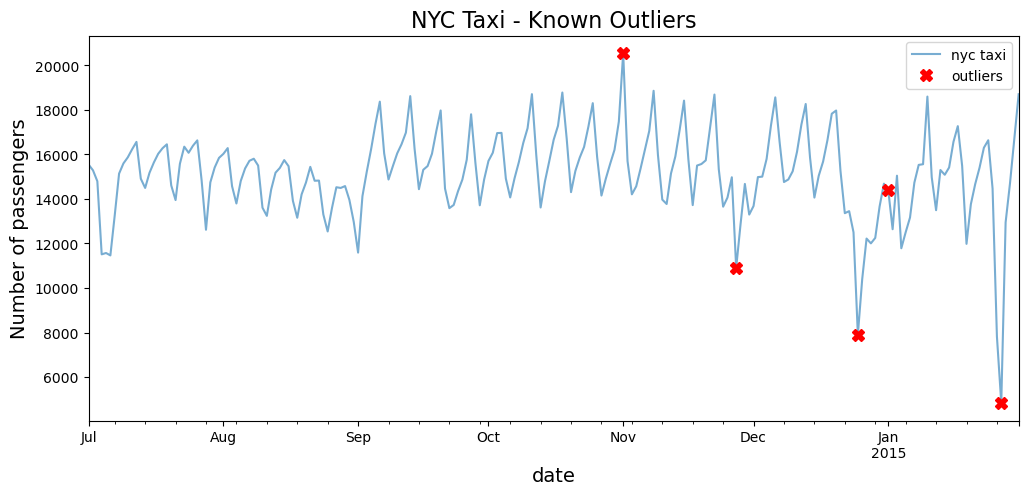

In [43]:
plot_outliers(known_outliers, tx, 'Known Outliers')

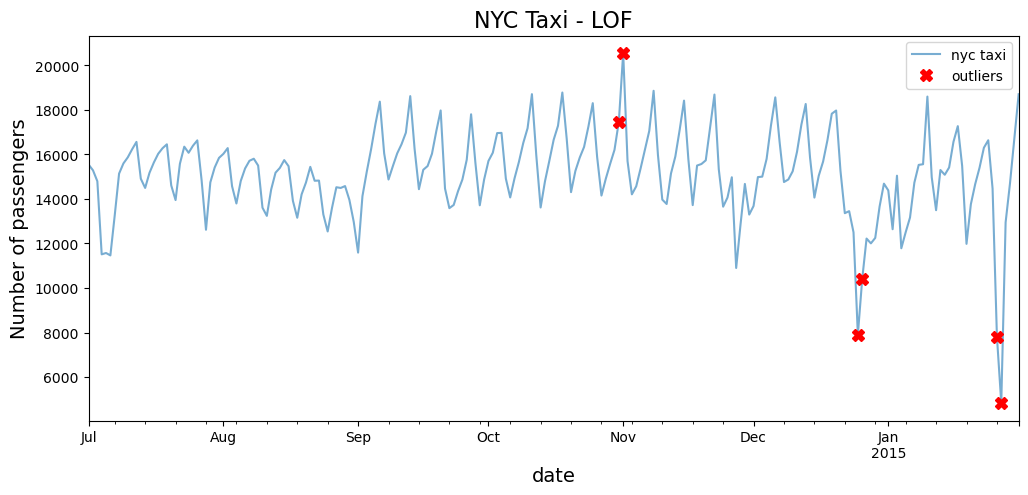

In [44]:
plot_outliers(outliers, tx, 'LOF')

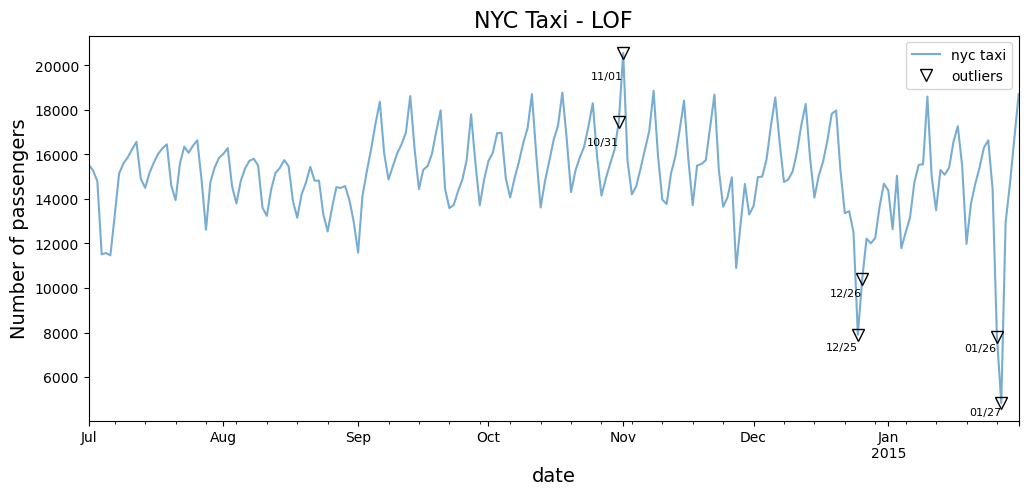

In [45]:
plot_outliers(outliers, tx, 'LOF', labels=True)

## There is more

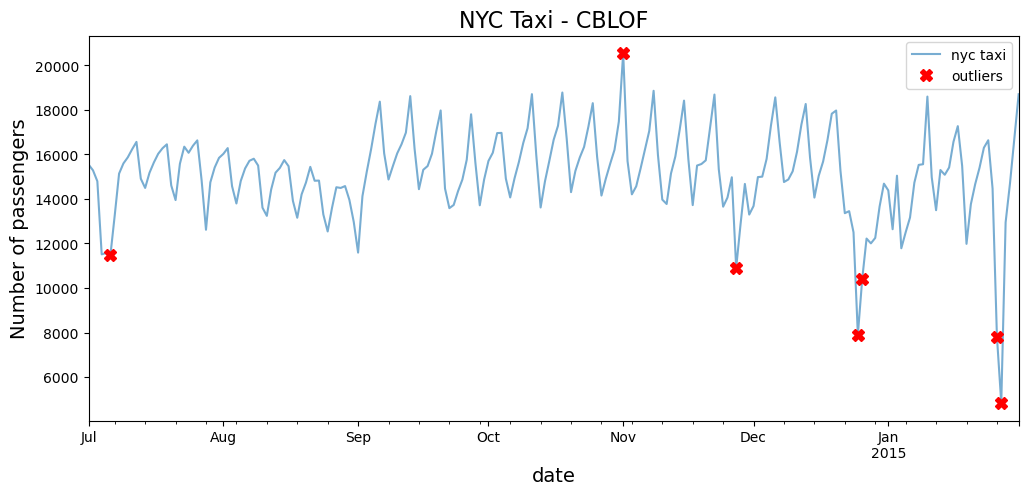

In [46]:
from pyod.models.cblof import CBLOF

cblof = CBLOF(n_clusters=4, contamination=0.03)   # Initialize CBLOF with 4 clusters and 3% contamination
cblof.fit(tx)                                     # Fit the CBLOF model to the data

predicted = pd.Series(cblof.predict(tx),          # Predict outliers using the CBLOF model
                      index=tx.index)

outliers = predicted[predicted == 1]              # Filter predicted outliers (1 = anomaly)
outliers = tx.loc[outliers.index]                 # Retrieve actual data values for outlier indices

plot_outliers(outliers, tx, 'CBLOF')              # Plot the detected CBLOF outliers

# Detecting Outliers using Isolation Forests

In [47]:
from pyod.models.iforest import IForest

In [48]:
iforest = IForest(contamination=0.03,     # Set the expected proportion of outliers to 3% of the dataset
                  n_estimators=100)       # Use 100 trees in the Isolation Forest ensemble for better accuracy
iforest.fit(tx)                           # Fit the Isolation Forest model to the time series data

IForest(behaviour='old', bootstrap=False, contamination=0.03,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=None, verbose=0)

In [49]:
predicted = pd.Series(iforest.predict(tx), # Predict anomalies using the trained Isolation Forest model (1 = outlier, 0 = inlier)
                      index=tx.index)      # Assign the original datetime index for alignment with the time series

In [50]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [51]:
outliers = predicted[predicted == 1]  # Filter the predictions to keep only the indices where the point was classified as an outlier (1)
outliers = tx.loc[outliers.index]     # Retrieve the actual values from the time series corresponding to those outlier indices
outliers                              # Display the detected outlier rows

value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

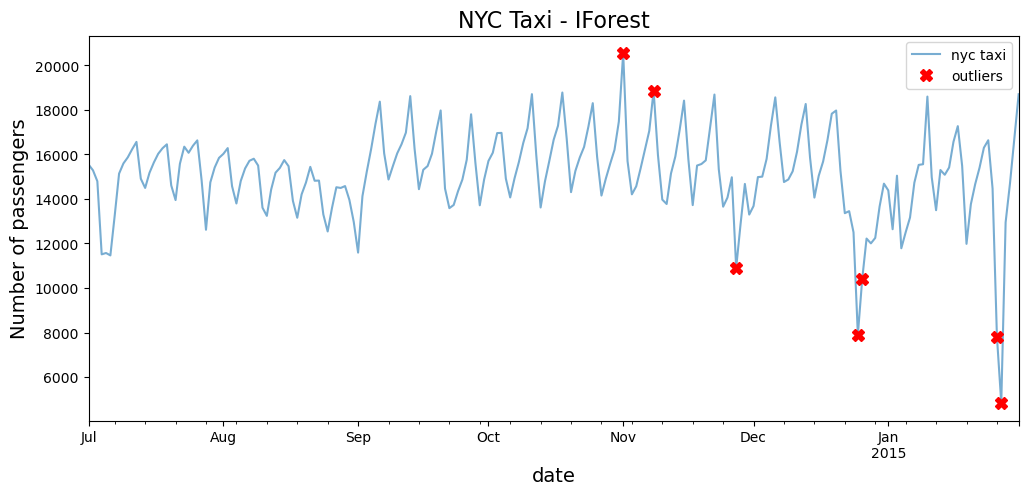

In [52]:
plot_outliers(outliers, tx, 'IForest')

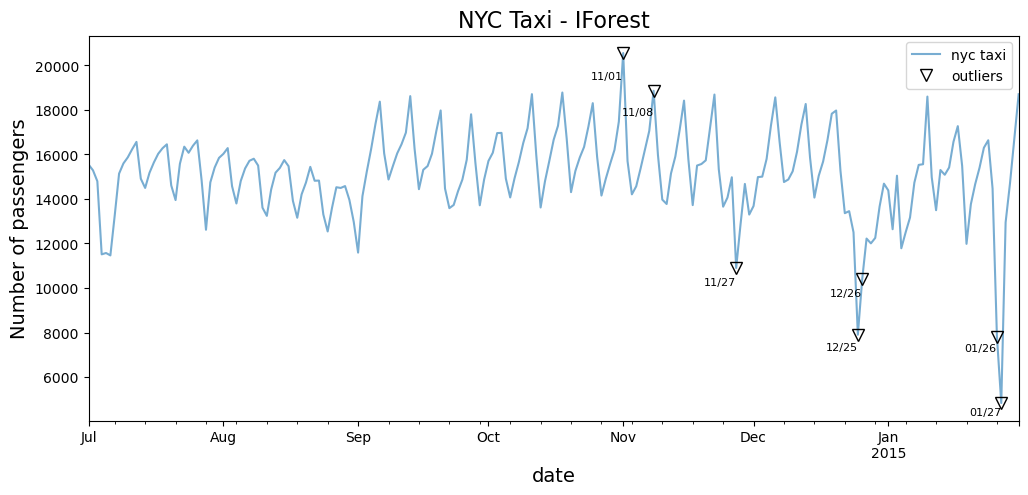

In [53]:
plot_outliers(outliers, 
              tx, 
              'IForest',
              labels=True)

In [54]:
# Returns the decision threshold used by the Isolation Forest to classify outliers based on the anomaly score
iforest.threshold_  

-7.147060721024445e-16

In [55]:
outliers

value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

In [56]:
iforest_scores = iforest.decision_scores_            # Get the raw anomaly scores from the Isolation Forest model

iforest_scores_df = (pd.DataFrame(iforest_scores,    # Create a DataFrame of scores
             index=tx.index, 
             columns=['score']))

iforest_scores_df[iforest_scores_df['score'] >=      # Filter the scores above or equal to the model's outlier threshold
                  iforest.threshold_].sort_values('score', ascending=False)   # Sort the outliers by score in descending order (most anomalous first)

score
timestamp           
2015-01-27  0.229988
2014-11-01  0.198942
2015-01-26  0.123712
2014-12-25  0.120650
2014-12-26  0.067230
2014-11-27  0.029619
2014-11-08  0.017570

## There is more

In [57]:
import sklearn
sklearn.__version__

'1.6.1'

In [58]:
from sklearn.ensemble import IsolationForest

In [59]:
sk_iforest = IsolationForest(contamination=0.03)        # Initialize scikit-learn's IsolationForest with 3% contamination

sk_prediction = pd.Series(sk_iforest.fit_predict(tx),   # Fit the model and get predictions (-1 = outlier, 1 = inlier)
                          index=tx.index)

sk_outliers = sk_prediction[sk_prediction == -1]        # Filter out the indices where the prediction is -1 (outliers)

sk_outliers = tx.loc[sk_outliers.index]                 # Retrieve the actual values from the time series for those outlier indices

sk_outliers                                             # Display the detected outlier rows

value
timestamp               
2014-11-01  20553.500000
2014-11-08  18857.333333
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

# Detecing Outliers using Copula-Based Outlier Detection (COPOD)

In [60]:
from pyod.models.copod import COPOD

In [61]:
copod = COPOD(contamination=0.03)  # Initialize the COPOD (Copula-Based Outlier Detection) model with 3% contamination

copod.fit(tx)                      # Fit the COPOD model to the time series data

COPOD(contamination=0.03, n_jobs=1)

In [62]:
predicted = pd.Series(copod.predict(tx),    # Predict anomalies using the trained COPOD model (1 = outlier, 0 = inlier)
                      index=tx.index)       # Preserve the original datetime index for proper alignment with the time series

In [63]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  7


In [64]:
outliers = predicted[predicted == 1]     # Filter to keep only the points labeled as outliers (1)
outliers = tx.loc[outliers.index]        # Retrieve the actual values from the time series at those outlier indices
outliers                                 # Display the detected outlier rows

value
timestamp               
2014-07-04  11511.770833
2014-07-06  11464.270833
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

In [65]:
known_outliers

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667

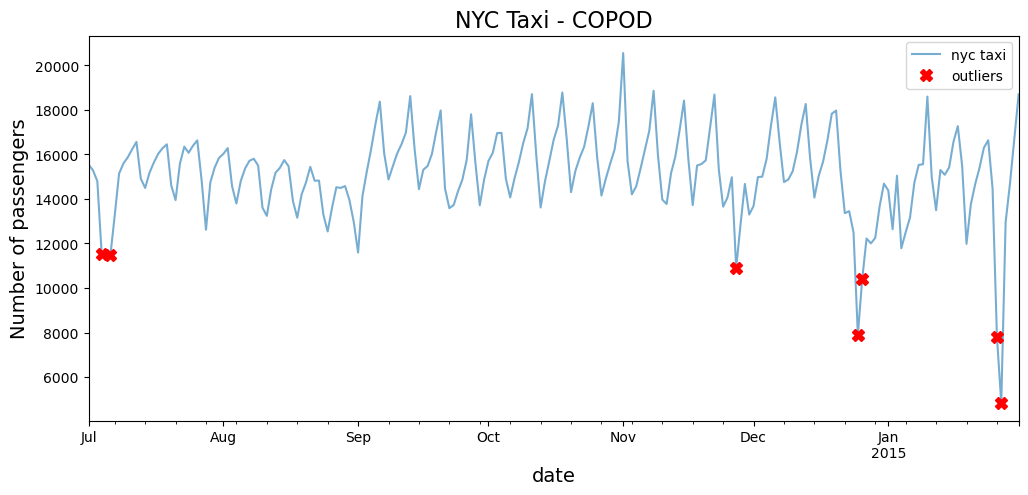

In [66]:
plot_outliers(outliers, tx, 'COPOD')

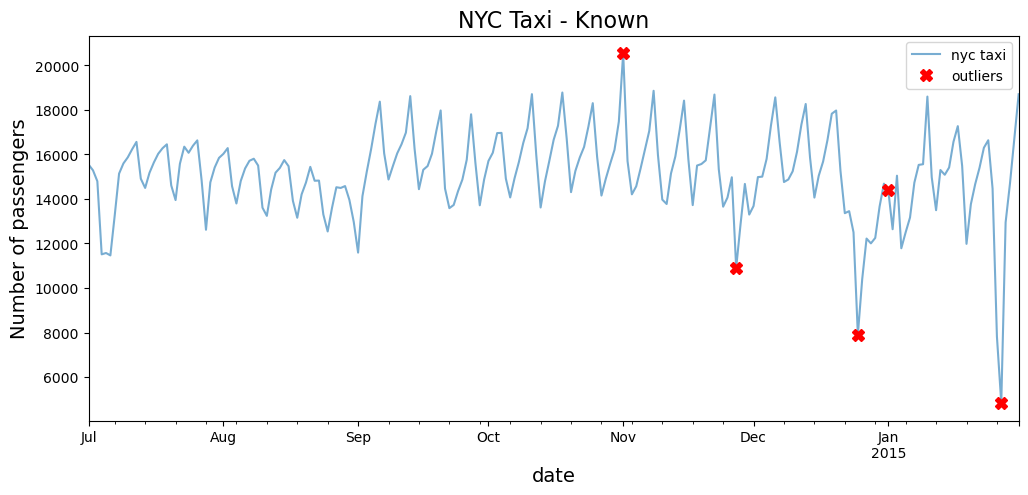

In [67]:
plot_outliers(known_outliers, tx, 'Known')

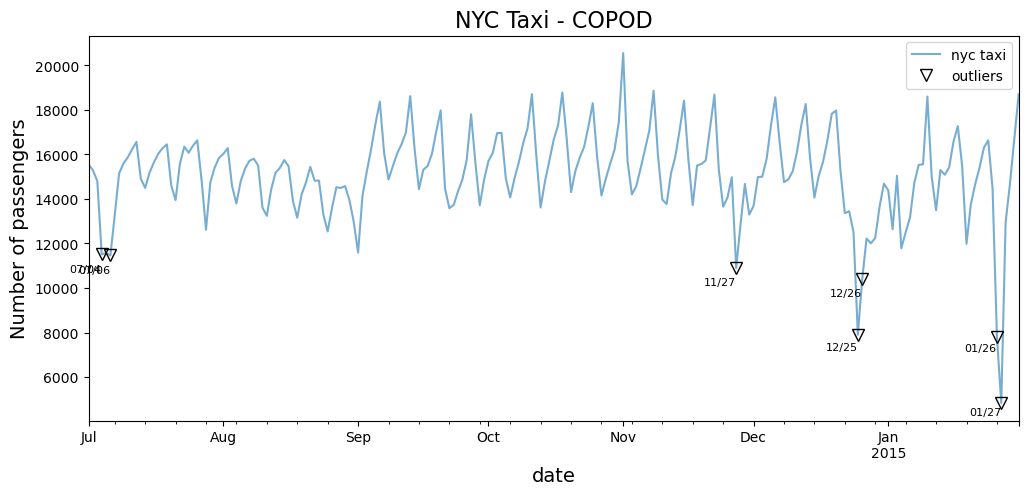

In [68]:
plot_outliers(outliers, 
              tx, 
              'COPOD',
              labels=True)

## MAD (Median Absolute Deviation)

In [69]:
from pyod.models.mad import MAD

In [70]:
# Initialize the MAD (Median Absolute Deviation) model with a threshold of 3 standard MAD units for outlier detection
mad = MAD(threshold=3)  

In [71]:
predicted = pd.Series(mad.fit_predict(tx),  # Fit the MAD model and get predictions (1 = outlier, 0 = inlier)
                      index=tx.index)       # Preserve original datetime index for alignment

outliers = predicted[predicted == 1]        # Filter the predictions to keep only the outlier indices
outliers = tx.loc[outliers.index]           # Retrieve the actual values from the time series for those outlier dates
outliers                                    # Display the detected outliers

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

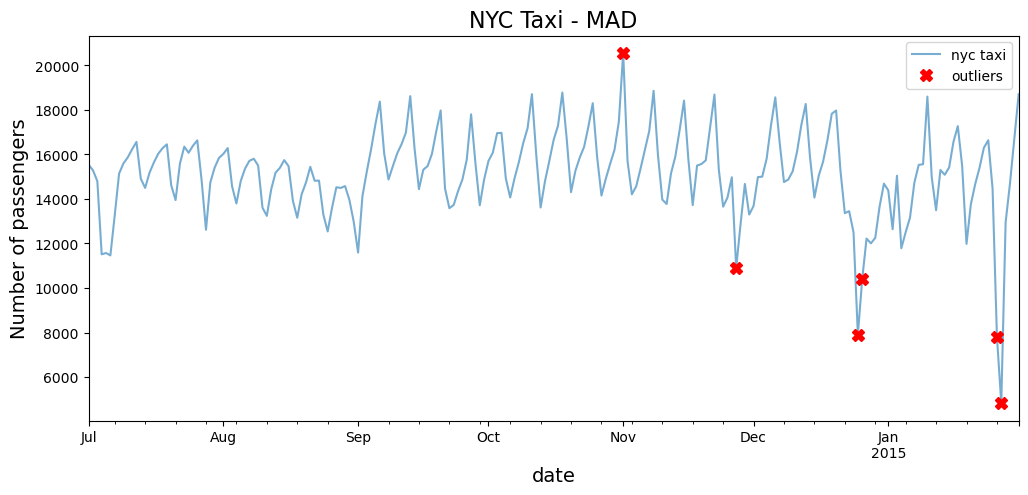

In [72]:
plot_outliers(outliers, tx, 'MAD')

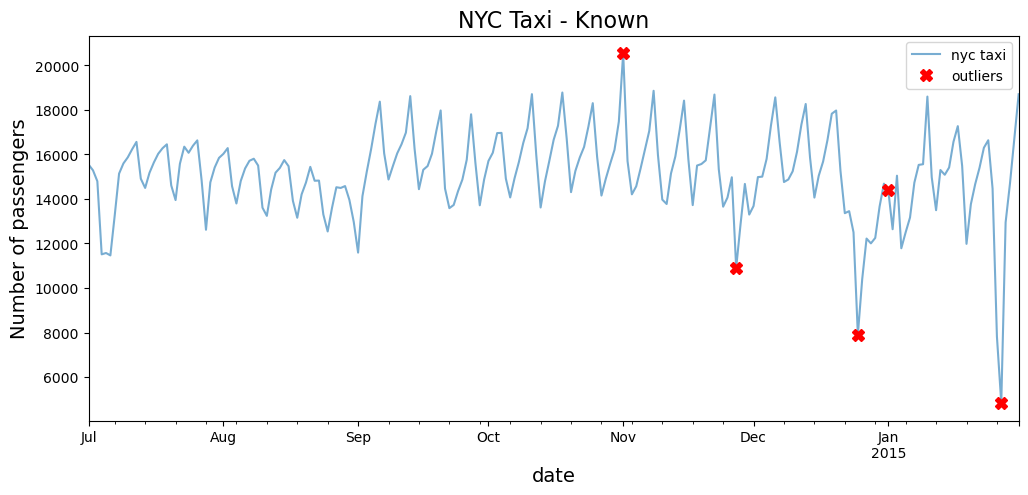

In [73]:
plot_outliers(known_outliers, tx, 'Known')

In [74]:
from pyod.models.loda import LODA

In [75]:
loda = LODA(contamination=0.03)  # Initialize the LODA (Lightweight On-line Detector of Anomalies) model with 3% contamination

loda.fit(tx)                     # Fit the LODA model to the time series data

LODA(contamination=0.03, n_bins=10, n_random_cuts=100)

In [76]:
predicted = pd.Series(loda.predict(tx),  # Predict anomalies using the trained LODA model (1 = outlier, 0 = inlier)
                      index=tx.index)    # Preserve the original datetime index for proper alignment

In [77]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  6


In [78]:
outliers = predicted[predicted == 1]  # Filter the prediction series to get only the indices marked as outliers (1)
outliers = tx.loc[outliers.index]     # Use those indices to retrieve the actual values from the original time series
outliers                              # Display the detected outlier rows

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

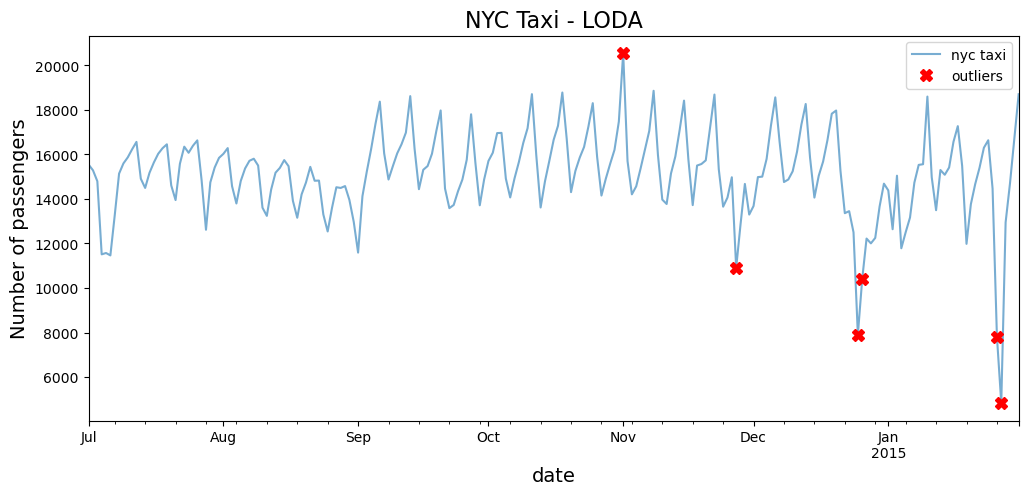

In [79]:
plot_outliers(outliers, tx, 'LODA')

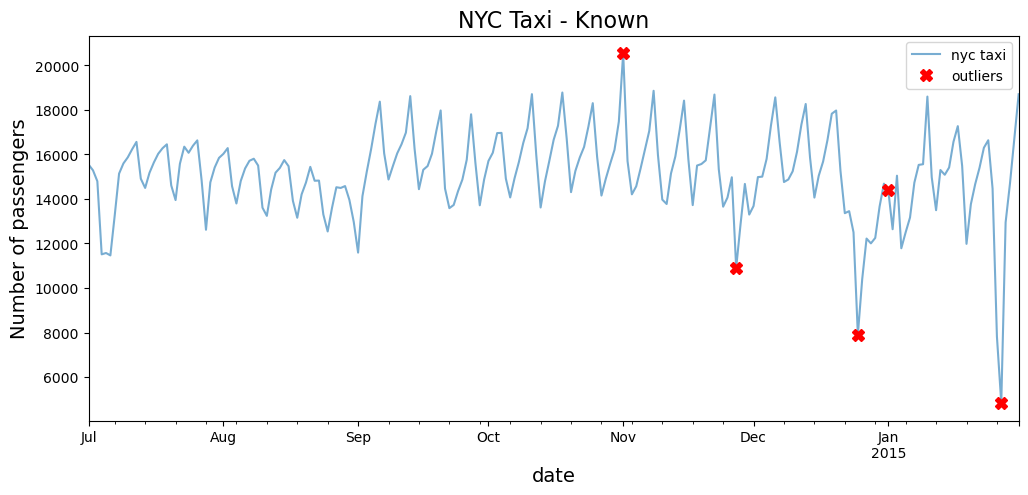

In [80]:
plot_outliers(known_outliers, tx, 'Known')

# Detecting Outliers using One Class SVM

In [81]:
from pyod.models.ocsvm import OCSVM

In [82]:
ocsvm = OCSVM(contamination=0.03, kernel='rbf')  # Initialize the One-Class SVM model with 3% contamination using a radial basis function kernel
ocsvm.fit(tx)                                    # Fit the OCSVM model to the time series data

OCSVM(cache_size=200, coef0=0.0, contamination=0.03, degree=3, gamma='auto',
   kernel='rbf', max_iter=-1, nu=0.5, shrinking=True, tol=0.001,
   verbose=False)

In [83]:
predicted = pd.Series(ocsvm.predict(tx),     # Predict anomalies using the trained OCSVM model (1 = outlier, 0 = inlier)
                      index=tx.index)        # Preserve the original datetime index for alignment

In [84]:
print('Number of outliers = ', predicted.sum())

Number of outliers =  5


In [85]:
outliers = predicted[predicted == 1]   # Filter to keep only the indices classified as outliers (1)
outliers = tx.loc[outliers.index]      # Retrieve the original time series values corresponding to those indices
outliers                               # Display the outlier rows from the data

value
timestamp               
2014-08-09  15499.708333
2014-11-18  15499.437500
2014-11-27  10899.666667
2014-12-24  12502.000000
2015-01-05  12502.750000

In [86]:
known_outliers

value
timestamp               
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2015-01-01  14383.479167
2015-01-27   4834.541667

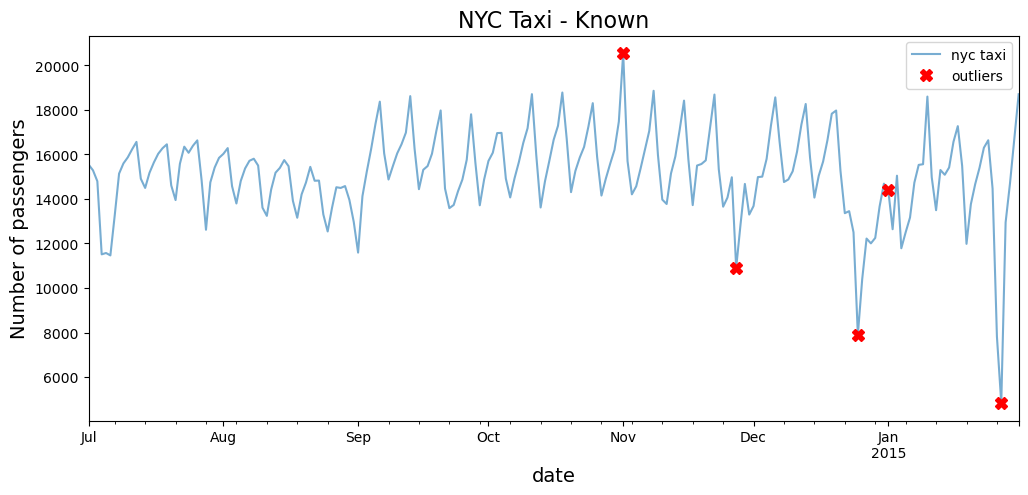

In [87]:
plot_outliers(known_outliers, tx, 'Known')

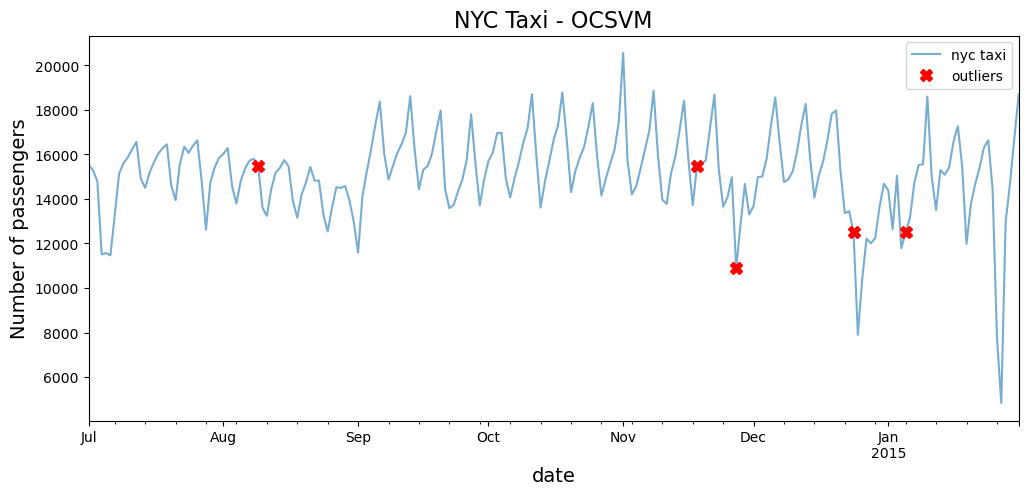

In [88]:
plot_outliers(outliers, tx, 'OCSVM')

In [89]:
from pyod.utils.utility import standardizer

scaled = standardizer(tx)                          # Standardize the time series data for better OCSVM performance

predicted = pd.Series(ocsvm.fit_predict(scaled),   # Fit the OCSVM model on the scaled data and predict anomalies (1 = outlier, 0 = inlier)
                      index=tx.index)              # Preserve the original datetime index

outliers = predicted[predicted == 1]               # Filter to get only the indices where outliers were detected

outliers = tx.loc[outliers.index]                  # Retrieve the corresponding values from the original (unscaled) time series
outliers                                           # Display the outlier values

value
timestamp               
2014-07-06  11464.270833
2014-11-01  20553.500000
2014-11-27  10899.666667
2014-12-25   7902.125000
2014-12-26  10397.958333
2015-01-26   7818.979167
2015-01-27   4834.541667

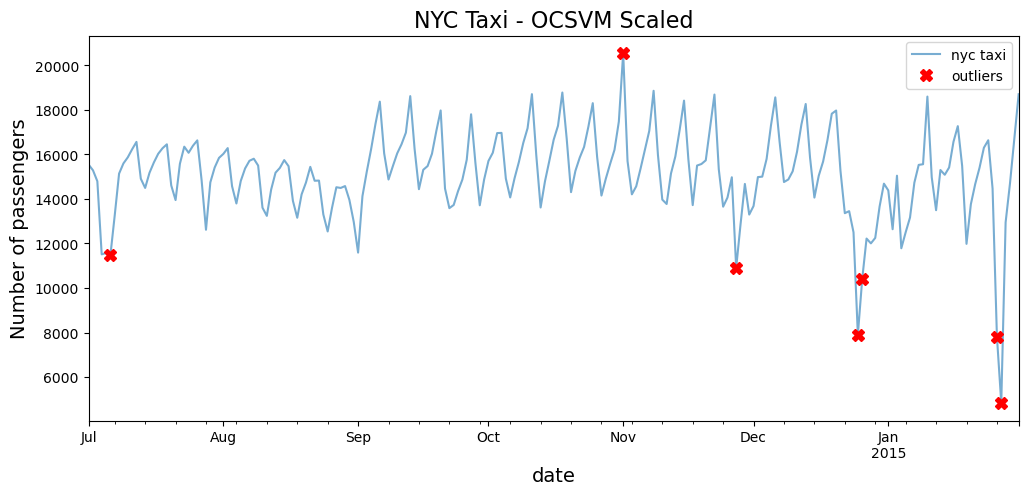

In [90]:
plot_outliers(outliers, tx, 'OCSVM Scaled')

## There is more

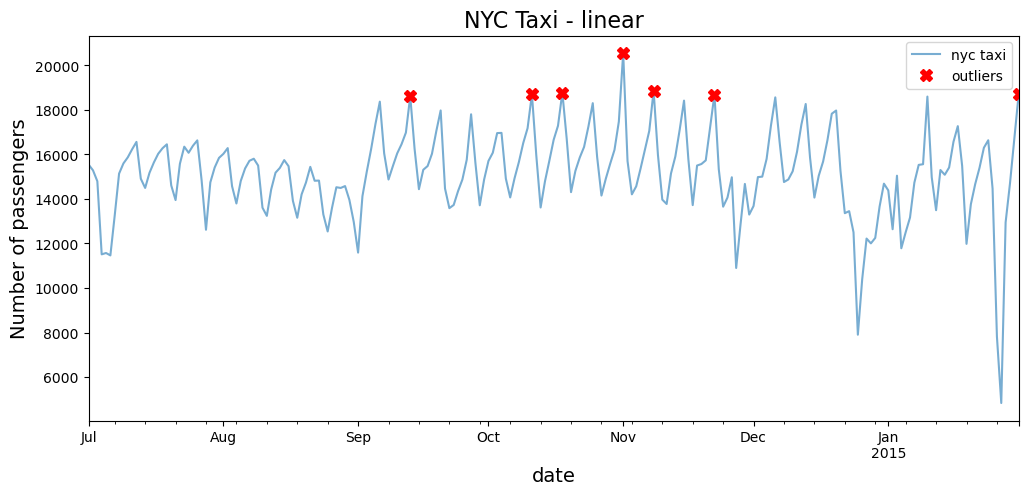

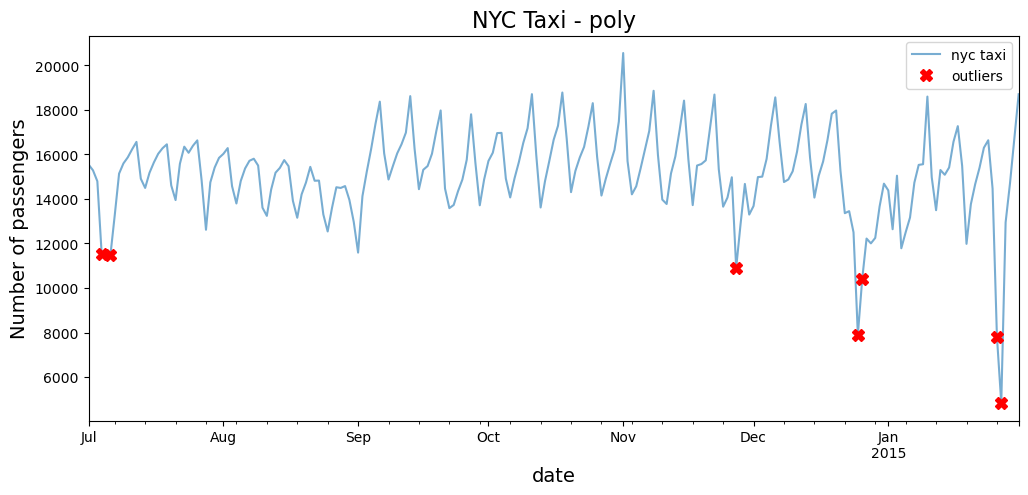

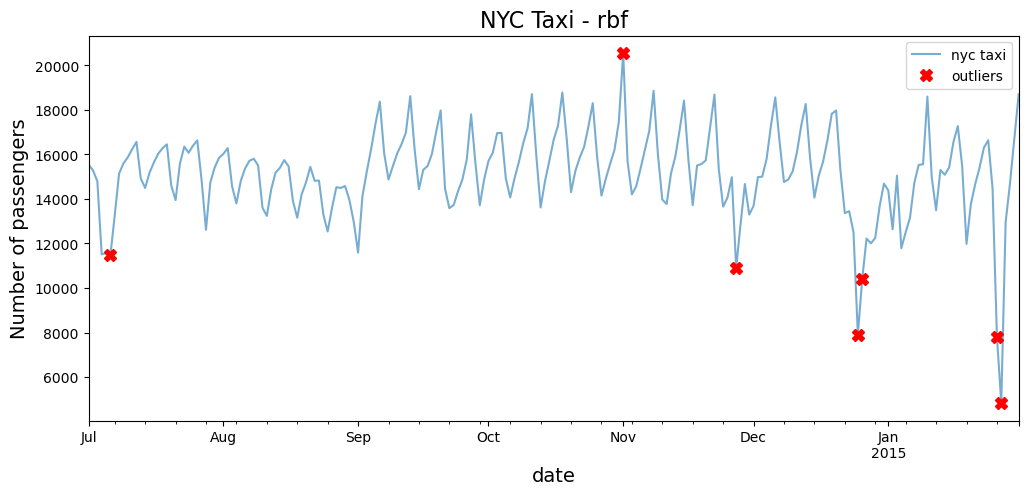

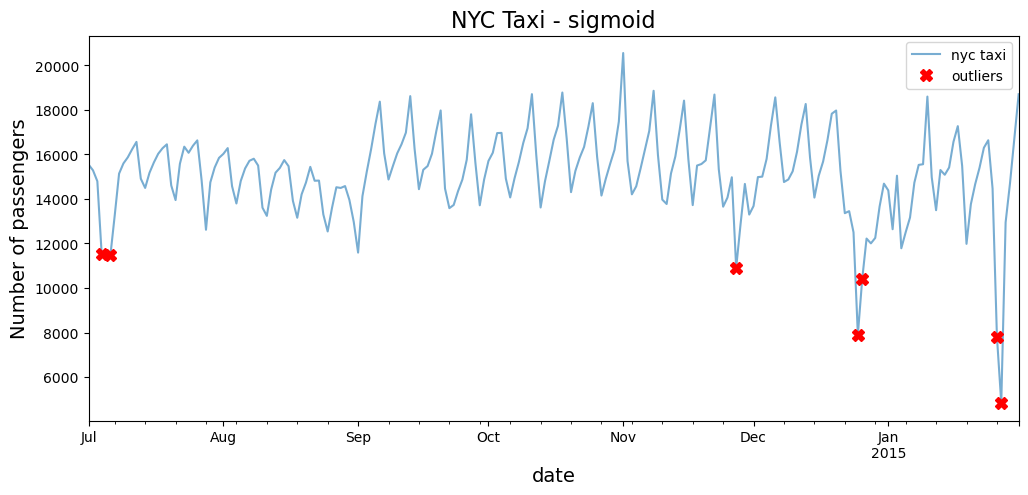

In [91]:
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:     # Iterate through various kernel types for OCSVM

    ocsvm = OCSVM(contamination=0.03, kernel=kernel)    # Initialize OCSVM with specified kernel and 3% contamination

    predict = pd.Series(ocsvm.fit_predict(scaled),      # Fit OCSVM on the standardized data and generate predictions
                        index=tx.index, name=kernel)

    outliers = predict[predict == 1]                    # Select indices of detected outliers (1 = anomaly)

    outliers = tx.loc[outliers.index]                   # Retrieve the actual time series values at those outlier indices

    plot_outliers(outliers, tx, kernel)                 # Visualize the outliers for each kernel type